# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

***Описание данных***

Признаки:
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата  

Целевой признак:
* Exited — факт ухода клиента

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Удалим колонки, которые не понадобятся для исследования.

In [4]:
data = data.drop(columns = ['CustomerId', 'RowNumber', 'Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Исправим названия колонок и приведём к нижнему регистру.

In [5]:
data.columns = map(str.lower, data.columns)
data = data.rename(columns = 
                   {'creditscore':'credit_score', 'numofproducts':'num_of_products', 'hascrcard':'has_cr_card', 'isactivemember':'is_active_member', 'estimatedsalary':'estimated_salary'})
data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
for column in data.columns: # цикл для определения значений всего датасета
    print(column)
    print(data[column].value_counts()) 
    print()

credit_score
850    233
678     63
655     54
667     53
705     53
      ... 
412      1
351      1
365      1
373      1
423      1
Name: credit_score, Length: 460, dtype: int64

geography
France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

gender
Male      5457
Female    4543
Name: gender, dtype: int64

age
37    478
38    477
35    474
36    456
34    447
     ... 
92      2
88      1
82      1
85      1
83      1
Name: age, Length: 70, dtype: int64

tenure
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

balance
0.00         3617
105473.74       2
130170.82       2
72594.00        1
139723.90       1
             ... 
130306.49       1
92895.56        1
132005.77       1
166287.85       1
104001.38       1
Name: balance, Length: 6382, dtype: int64

num_of_products
1    5084
2    4590
3     266
4      60
Name: num_of_products, dtype: int64

has_c

Text(0, 0.5, 'Количество человек')

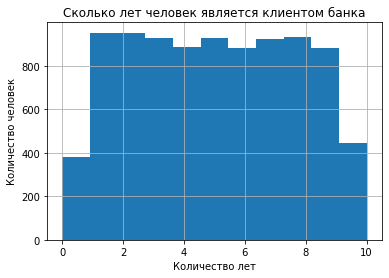

In [7]:
data['tenure'].hist(bins=11)
plt.title('Сколько лет человек является клиентом банка')
plt.xlabel('Количество лет')
plt.ylabel('Количество человек')

Заменим пропуски в столбце "tenure" с информацией о количестве лет, на протяжение которых человек является клиентом банка средним значением по категориям: кредитный рейтинг, количество продуктов банка, пол и страна. Оставшиеся пропуски заменим средним. И заменим тип данных на цельночисленный.

In [8]:
data['tenure'] = data['tenure'].fillna(data.groupby(['credit_score', 'num_of_products', 'geography', 'gender'])['tenure'].transform('mean'))
data['tenure'] = data['tenure'].fillna(data['tenure'].mean())
data = data.astype({'tenure':'int'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Преобразовать категориальные признаки Geography, Gender в численные поможет техника прямого кодирования, или отображения (OHE).

In [9]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


### Вывод

Нами изучен датасет, состоящий из 10 000 строк и 14 колонок с информацией о клиентах банка. Мы изменили названия колонок в дтафрейме, заполнили пропуски в периоде, в течение которогоо клиент является клиентом банка, избавились от ненужной информации(столбцы с фамилией клиентов и индексом строки). Заменили тип данных и преобразовали категориальные признаки в численные. Так же отметили, что большая часть клиентов - мужчины, >50% клиентов банка из Франции, 3617 клиентов имеют на болансе 0.


## Исследование задачи

Разделим датасет на целевой и остальные признаки, а выборки - на обучающую и валидационную.

In [10]:
features = data_ohe.drop('exited', axis=1)
target = data_ohe['exited']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target , test_size=0.25, random_state=12345)

#стандартизируем числовые данные, используя StandardScaler
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_valid = scaler.transform(features_valid)

print(features_train.shape)
print(features_valid.shape)


(7500, 11)
(2500, 11)


In [11]:
features[target == 0].shape, features[target == 1].shape 

((7963, 11), (2037, 11))

Соотношение отрицательного и положительного класса примерно 4:1. Так как на данном этапе мы работаем без учёта дисбаланса классов, то и хороших результатов не ожидаем.

### Дерево решений

In [12]:
%%time
for depth in range(1,21):
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model_tree.fit(features_train, target_train)
    predictions = model_tree.predict(features_valid)
    print('max_depth:', depth,'F1:', f1_score(target_valid, predictions))

max_depth: 1 F1: 0.0
max_depth: 2 F1: 0.5287846481876333
max_depth: 3 F1: 0.45152722443559096
max_depth: 4 F1: 0.4850843060959793
max_depth: 5 F1: 0.5697940503432494
max_depth: 6 F1: 0.546134663341646
max_depth: 7 F1: 0.5472154963680387
max_depth: 8 F1: 0.5301204819277108
max_depth: 9 F1: 0.5487944890929967
max_depth: 10 F1: 0.5505376344086022
max_depth: 11 F1: 0.5523012552301254
max_depth: 12 F1: 0.5222797927461139
max_depth: 13 F1: 0.5287588294651867
max_depth: 14 F1: 0.5074925074925075
max_depth: 15 F1: 0.5212240868706811
max_depth: 16 F1: 0.5019157088122606
max_depth: 17 F1: 0.49763481551561023
max_depth: 18 F1: 0.4919886899151744
max_depth: 19 F1: 0.4940092165898617
max_depth: 20 F1: 0.4958061509785648
CPU times: user 498 ms, sys: 4.85 ms, total: 503 ms
Wall time: 530 ms


Лучшее значение max_depth=5, при котором F1=0,569.

### Случайный лес

In [13]:
%%time
for max_depth in range(1,20):
    model_forest = RandomForestClassifier(max_depth=max_depth, n_estimators=50, random_state=1234)
    model_forest.fit(features_train, target_train)
    predictions = model_forest.predict(features_valid)
    print('max_depth:', max_depth,'F1:', f1_score(target_valid, predictions))

max_depth: 1 F1: 0.0
max_depth: 2 F1: 0.17035775127768313
max_depth: 3 F1: 0.22512234910277323
max_depth: 4 F1: 0.32683658170914537
max_depth: 5 F1: 0.39544807965860596
max_depth: 6 F1: 0.5026315789473684
max_depth: 7 F1: 0.528735632183908
max_depth: 8 F1: 0.5459119496855345
max_depth: 9 F1: 0.5576208178438662
max_depth: 10 F1: 0.5717761557177615
max_depth: 11 F1: 0.5731559854897219
max_depth: 12 F1: 0.5693606755126659
max_depth: 13 F1: 0.5700598802395209
max_depth: 14 F1: 0.5748218527315914
max_depth: 15 F1: 0.5737898465171193
max_depth: 16 F1: 0.5734597156398105
max_depth: 17 F1: 0.5700824499411071
max_depth: 18 F1: 0.5747663551401868
max_depth: 19 F1: 0.5602836879432623
CPU times: user 5.52 s, sys: 26.4 ms, total: 5.55 s
Wall time: 6.39 s


Лучшее значение max_depth=14, при котором F1=0,574.  

Теперь подберём гиперпараметр с количеством деревьев при глубине 14.

In [14]:
%%time
for estim in range(1,100,5):
    model_forest = RandomForestClassifier(max_depth=14, n_estimators=estim, random_state=1234)
    model_forest.fit(features_train, target_train)
    predictions = model_forest.predict(features_valid)
    print('estim',estim,'F1:',f1_score(target_valid, predictions))

estim 1 F1: 0.49543147208121824
estim 6 F1: 0.5367561260210035
estim 11 F1: 0.5697674418604651
estim 16 F1: 0.5547785547785546
estim 21 F1: 0.5774647887323944
estim 26 F1: 0.5775147928994082
estim 31 F1: 0.5778301886792453
estim 36 F1: 0.5751173708920188
estim 41 F1: 0.5775147928994082
estim 46 F1: 0.5758293838862559
estim 51 F1: 0.5738095238095238
estim 56 F1: 0.5795724465558194
estim 61 F1: 0.5697258641239571
estim 66 F1: 0.562874251497006
estim 71 F1: 0.559423769507803
estim 76 F1: 0.5615292712066906
estim 81 F1: 0.5622775800711743
estim 86 F1: 0.5619047619047619
estim 91 F1: 0.5608591885441528
estim 96 F1: 0.563614744351962
CPU times: user 7.39 s, sys: 31.1 ms, total: 7.42 s
Wall time: 7.46 s


Лучшее значение max_depth = 14 и n_estimators = 56, при котором F1=0,579.

### Логистическая регрессия

In [15]:
model_logistic = LogisticRegression().fit(features_train, target_train)
predictions = model_logistic.predict(features_valid)
print('F1:', f1_score(target_valid, predictions))

F1: 0.2944444444444444


### Вывод

Из трёх расмотренных моделей лучшее значение у случайного леса с параметрами max_depth = 14 и n_estimators = 56, при котором F1=0,579.

## Борьба с дисбалансом

Воспользуемся функцией Upsampling и увеличим количество клиентов оттока(target==1), чтобы сделать объекты редкого класса не такими редкими.

In [16]:
def upsample(features, target, repeat):
    features_zeros = pd.DataFrame(features[target == 0])
    features_ones = pd.DataFrame(features[target == 1])
    target_zeros = pd.DataFrame(target[target == 0])
    target_ones = pd.DataFrame(target[target == 1])

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.42938347179711406


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


И функцией Downsample, чтобы объекты частого класса сделать не такими частыми.

In [17]:
def downsample(features, target, fraction):
    features_zeros = pd.DataFrame(features[target == 0])
    features_ones = pd.DataFrame(features[target == 1])
    target_zeros = pd.DataFrame(target[target == 0])
    target_ones = pd.DataFrame(target[target == 1])

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


F1: 0.4308510638297872


При борьбе с дисбалансом функция Upsampling дала результат F1 = 0.429, Downsample - F1 = 0.430

## Тестирование модели

### Дерево решений после балансироки данных

In [18]:
%%time
for depth in range(1,20,1):
    model_tree = DecisionTreeClassifier(class_weight='balanced', max_depth=depth, random_state=1234).fit(features_upsampled, target_upsampled)
  
    predictions = model_tree.predict(features_valid)
    print('max_depth:', depth, 'F1:', f1_score(target_valid, predictions))

max_depth: 1 F1: 0.5070202808112324
max_depth: 2 F1: 0.5391566265060241
max_depth: 3 F1: 0.5391566265060241
max_depth: 4 F1: 0.5440414507772021
max_depth: 5 F1: 0.6016129032258064
max_depth: 6 F1: 0.5883201153568853
max_depth: 7 F1: 0.5782122905027933
max_depth: 8 F1: 0.5762962962962963
max_depth: 9 F1: 0.5753424657534246
max_depth: 10 F1: 0.549079754601227
max_depth: 11 F1: 0.5434782608695652
max_depth: 12 F1: 0.5352564102564102
max_depth: 13 F1: 0.5132450331125827
max_depth: 14 F1: 0.49786871270247224
max_depth: 15 F1: 0.5048715677590788
max_depth: 16 F1: 0.5081374321880651
max_depth: 17 F1: 0.5060018467220684
max_depth: 18 F1: 0.5116713352007469
max_depth: 19 F1: 0.5028462998102466
CPU times: user 973 ms, sys: 69.5 ms, total: 1.04 s
Wall time: 1.11 s


Лучшее значение max_depth=5, при котором F1=0,601. До борьбы с дисбалансом F1=0,569.

###  Случайный лес после балансироки данных

In [19]:
%%time
for max_depth in range(1,20):
    model_forest = RandomForestClassifier(class_weight='balanced',max_depth=max_depth,n_estimators=50,random_state=1234).fit(features_downsampled,target_downsampled)
    predictions = model_forest.predict(features_valid)
    print('max_depth:', max_depth, 'F1:', f1_score(target_valid, predictions))

max_depth: 1 F1: 0.5466847090663058
max_depth: 2 F1: 0.5718290119131044


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


max_depth: 3 F1: 0.5886475122634899
max_depth: 4 F1: 0.594785059901339


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


max_depth: 5 F1: 0.5995777621393386
max_depth: 6 F1: 0.5981956974323387


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


max_depth: 7 F1: 0.5902964959568733
max_depth: 8 F1: 0.5725388601036269


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


max_depth: 9 F1: 0.5608856088560885
max_depth: 10 F1: 0.5536992840095466


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


max_depth: 11 F1: 0.5280269058295964
max_depth: 12 F1: 0.5153970826580228


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


max_depth: 13 F1: 0.5072916666666667
max_depth: 14 F1: 0.5036420395421436


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


max_depth: 15 F1: 0.4876822523881348
max_depth: 16 F1: 0.4969387755102041


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


max_depth: 17 F1: 0.494212380473075
max_depth: 18 F1: 0.4982278481012658


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


max_depth: 19 F1: 0.495959595959596
CPU times: user 2.51 s, sys: 11.8 ms, total: 2.53 s
Wall time: 2.57 s


In [20]:
%%time
for estim in range(1,100, 5):
    model_forest = RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=estim, random_state=1234).fit(features_downsampled, target_downsampled)
    predictions = model_forest.predict(features_valid)
    print('estim:', estim, 'F1:', f1_score(target_valid, predictions))

estim: 1 F1: 0.5166204986149585
estim: 6 F1: 0.6038001407459536
estim: 11 F1: 0.5900068446269677
estim: 16 F1: 0.5991792065663475
estim: 21 F1: 0.597544338335607


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), f

estim: 26 F1: 0.5971755211835912
estim: 31 F1: 0.592741935483871
estim: 36 F1: 0.5962059620596206


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


estim: 41 F1: 0.5928426738690075
estim: 46 F1: 0.5955132562882393


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


estim: 51 F1: 0.589430894308943
estim: 56 F1: 0.5899864682002707


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


estim: 61 F1: 0.5964673913043478
estim: 66 F1: 0.5953678474114441


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


estim: 71 F1: 0.5945578231292518
estim: 76 F1: 0.59375


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


estim: 81 F1: 0.5905405405405405


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


estim: 86 F1: 0.591644204851752


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


estim: 91 F1: 0.5952542372881356


<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


estim: 96 F1: 0.5944482058226134
CPU times: user 2.5 s, sys: 4.27 ms, total: 2.5 s
Wall time: 2.54 s


Было: лучшее значение max_depth = 17 и n_estimators = 86, при котором F1=0,578.
После балансировки данных: лучшее значение max_depth = 7 и n_estimators = 46, при котором F1=0,605.

###  Логистическая регрессия после балансироки данных

In [21]:
model_logistic = LogisticRegression(class_weight='balanced', solver='liblinear').fit(features_downsampled,target_downsampled)
predictions = model_logistic.predict(features_valid)
print('F1:', f1_score(target_valid, predictions))

F1: 0.5093085106382979


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Среднее значение полноты и точности до 0.296 и после балансировки 0.509

### Вывод
Лучшие результаты показала модель случайного леса с параметрами max_depth = 7 и n_estimators = 46, при котором F1 = 0,605.

## Исследование метрики AUC-ROC

Посмотрим, как сильно наши модель отличаются от случайной.

In [22]:
probabilities_tree = model_tree.predict_proba(features_valid)
probabilities_one_valid_tree = probabilities_tree[:,1]
fpr_tree, tpr_tree, thresholds = roc_curve(target_valid, probabilities_one_valid_tree)

auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)
auc_roc_tree

0.6837435494994174

In [23]:
probabilities_forest = model_forest.predict_proba(features_valid)
probabilities_one_valid_forest = probabilities_forest[:,1]
fpr_forest, tpr_forest, thresholds = roc_curve(target_valid, probabilities_one_valid_forest)
auc_roc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)
auc_roc_forest

0.8598901334094314

In [24]:
probabilities_reg = model_logistic.predict_proba(features_valid)
probabilities_one_valid_reg = probabilities_reg[:,1]
fpr_log, tpr_log, thresholds = roc_curve(target_valid, probabilities_one_valid_reg)
auc_roc_reg = roc_auc_score(target_valid, probabilities_one_valid_reg)
auc_roc_reg

0.7648350812109106

<Figure size 432x288 with 0 Axes>

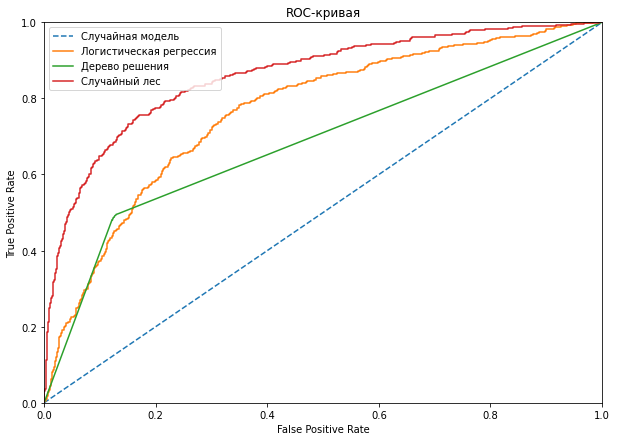

In [25]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_log,tpr_log)
plt.plot(fpr_tree,tpr_tree)
plt.plot(fpr_forest,tpr_forest)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель', 'Логистическая регрессия', 'Дерево решения', 'Случайный лес'),
           loc= 'upper left');

## Вывод
Рассматривая данные без и с учетом дисбаланса тремя моделями можно сделать вывод, что самая лучшая модель оказалась случайный лес. При лучшем значении max_depth=7, n_estimators=46, мы имеем F1 меру = 0,605 на валидационной выборке. Именно эта модель с большей точнойсть сможет спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Хуже всего себя показала модель Логистическая регрессия.